In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('S&P500.csv', sep=";", index_col="Date")

In [3]:
scaler = MinMaxScaler(feature_range=(-1,1))
df['Closing Price'] = scaler.fit_transform(df['Closing Price'].values.reshape(-1,1))
data_raw = df['Closing Price'].values

In [4]:
data = []
window_size = 70
train_ratio = 0.8


for i in range(len(data_raw) - window_size):
    data.append(data_raw[i : i + window_size])

data = np.array(data)
data = data.reshape((data.shape[0], data.shape[1], 1))
train_size = int(train_ratio * data.shape[0])
x_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor)

x_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor)

In [5]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out


model = LSTM(input_dim=1, hidden_dim=40, num_layers=2, output_dim=1)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [6]:
numEpochs = 80
history = np.zeros(numEpochs)
for t in range(numEpochs):
    y_train_pred = model(x_train)
    loss = loss_fn(y_train_pred, y_train)
    history[t] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if t % 10 == 0 and t != 0:
        print("Epoch", t)
        print("Train MSE:", history[t])
        y_test_pred = model(x_test)
        loss = loss_fn(y_test_pred, y_test)
        print("Test MSE:", loss.item())
        print()
    




Epoch 10
Train MSE: 0.03501402214169502
Test MSE: 0.07418160885572433

Epoch 20
Train MSE: 0.010549856349825859
Test MSE: 0.05489381030201912

Epoch 30
Train MSE: 0.0065480065532028675
Test MSE: 0.006573371589183807

Epoch 40
Train MSE: 0.0026204027235507965
Test MSE: 0.005418766289949417

Epoch 50
Train MSE: 0.0020299870520830154
Test MSE: 0.006711072288453579

Epoch 60
Train MSE: 0.0013765027979388833
Test MSE: 0.003732703160494566

Epoch 70
Train MSE: 0.0013390097301453352
Test MSE: 0.003153598867356777



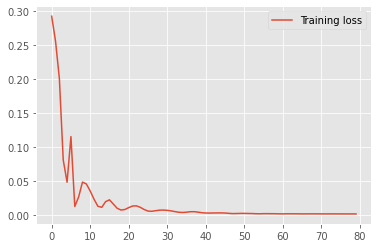

In [7]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.plot(history, label="Training loss")
plt.legend()
plt.show()
plt.savefig('loss.png')

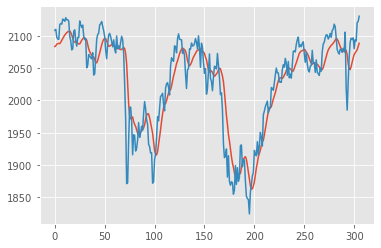

In [8]:
y_test_pred_graph = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test_graph = scaler.inverse_transform(y_test.detach().numpy())

plt.plot(y_test_pred_graph)
plt.plot(y_test_graph)
plt.show()
plt.savefig('prediction.png')